### Data Shifting Experiment

### SatelliteBench

* [Dataset](https://physionet.org/content/multimodal-satellite-data/1.0.0/)

* [Paper](https://arxiv.org/abs/2401.11114)

In [1]:
%cd ..

/home/datascience/Data Fusion


In [2]:
import os
import numpy as np
import pandas as pd

from src.classifiers import preprocess_data, process_labels, split_data
from src.classifiers import VQADataset
from torch.utils.data import DataLoader
from src.classifiers import train_early_fusion, train_late_fusion

from utils import normalize_embeddings, modify_and_normalize_embeddings, visualize_embeddings, plot_results, update_column_names

In [3]:
PATH = 'Embeddings_vlm/satellitedata/'
FILE = 'embeddings_clip.csv'
DATASET = 'SatelliteBench'

batch_size = 64

multilabel = False

num_epochs = 50

In [4]:
df = pd.read_csv(os.path.join(PATH, FILE))
df.drop(columns=['image_id', 'text'], inplace=True)
df.Labels = df.Labels.astype(str)
df.head()

,dx,split,image_embedding_0,image_embedding_1,image_embedding_2,image_embedding_3,image_embedding_4,image_embedding_5,image_embedding_6,image_embedding_7,...,text_embedding_502,text_embedding_503,text_embedding_504,text_embedding_505,text_embedding_506,text_embedding_507,text_embedding_508,text_embedding_509,text_embedding_510,text_embedding_511
0,nv,train,0.017459,-0.006133,0.042509,0.032119,-0.020298,-0.029999,-0.019345,-0.005980,...,-0.085103,-0.035549,0.022616,0.014842,-0.010682,0.007425,-0.010183,0.059058,0.028891,0.073401
1,nv,train,0.013314,-0.004718,0.036896,0.013657,-0.018710,-0.000790,-0.018275,0.021898,...,-0.024121,0.001504,0.007381,0.028216,-0.033343,-0.007173,0.025764,0.037911,-0.028967,0.032034
2,akiec,train,0.023076,-0.006460,0.046531,-0.007525,-0.052272,0.024759,-0.004904,0.024593,...,-0.076046,-0.025927,0.019258,0.013950,-0.013910,0.000220,-0.016514,0.060165,0.028732,0.068683
3,nv,train,0.002341,-0.042092,0.056254,0.000176,-0.013943,0.011410,0.002411,0.001611,...,-0.017013,-0.020450,0.020093,0.021699,-0.018428,0.018907,0.022027,0.045309,-0.014772,0.017288
4,nv,train,0.012029,-0.003644,0.028491,0.017455,-0.017562,-0.005040,0.016783,0.031028,...,-0.093017,-0.022929,0.013042,0.007998,-0.020830,-0.015631,-0.007309,0.057171,0.030298,0.068561


In [5]:
# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column]
image_columns = [column for column in df.columns if 'image' in column]
label_columns = 'dx'
output_size = len(pd.unique(df[label_columns]))

### Run Experiments

##################################################  Shift -1  ##################################################


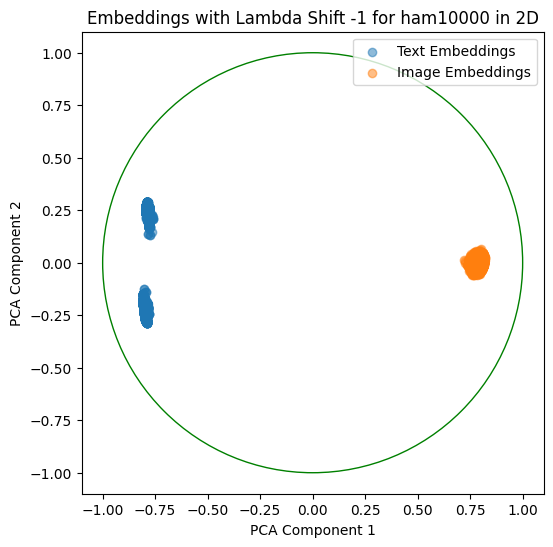

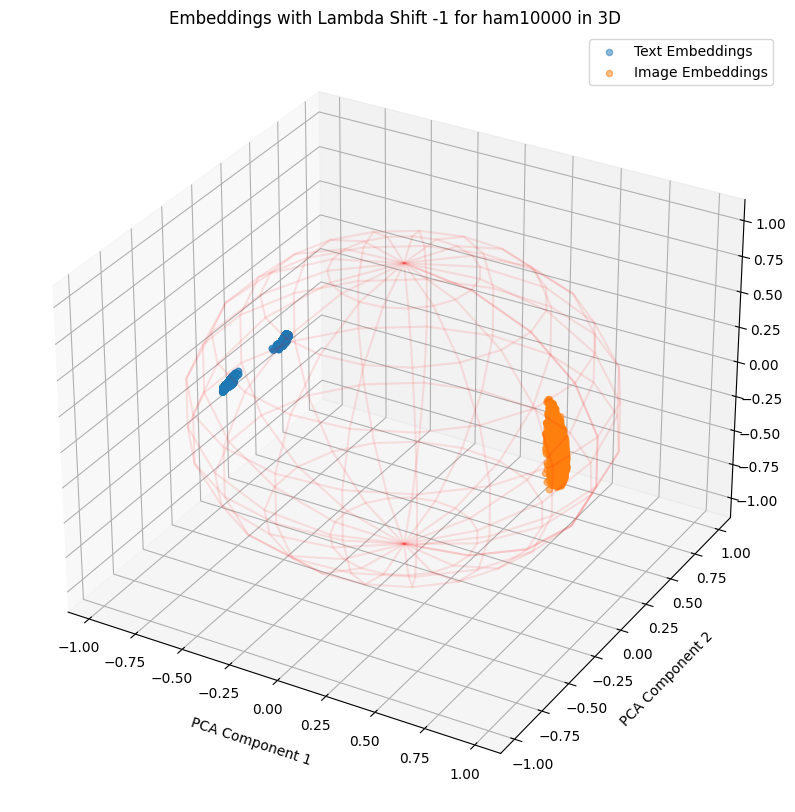

Train Shape: (8012, 1026)
Test Shape: (2003, 1026)
Training Early Fusion Model:
The number of parameters of the model are: 132359
Average Training Time per Epoch: 0.48 seconds
Total Training Time per Epoch: 24.18 seconds
Average Inference Time per Epoch: 0.15 seconds
Total Inference Time per Epoch: 7.47 seconds


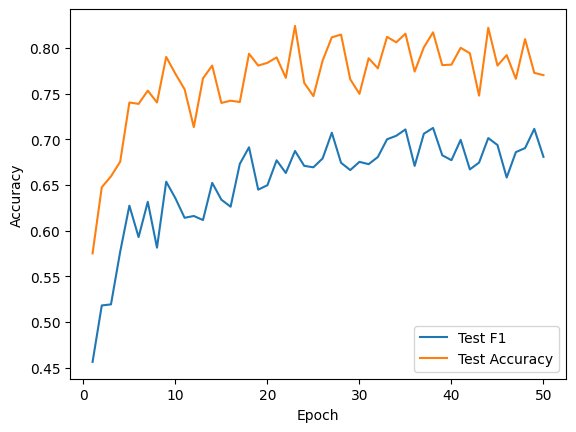

Best Accuracy: {'Acc': 0.8242636045931103, 'F1': 0.6873003101867284, 'Epoch': 23}
Best Macro-F1: {'Acc': 0.8172740888666999, 'F1': 0.7125369905581292, 'Epoch': 38}
Training Late Fusion Model:
The number of parameters of the model are: 66823


In [ ]:
# Assuming df is your DataFrame
lambda_shift_values = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Negative values bring embeddings closer, positive values push them apart
#lambda_shift_values = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]  # Negative values bring embeddings closer, positive values push them apart

# Normalize initial embeddings
df[text_columns] = normalize_embeddings(df[text_columns].values)
df[image_columns] = normalize_embeddings(df[image_columns].values)

# Dataframe with shifted values:
df_shifted = df.copy()

results = {}

for lambda_shift in lambda_shift_values:
    
    print('#'*50, f' Shift {lambda_shift} ', '#'*50)
    
    # Extract embeddings
    text_embeddings = df[text_columns].values
    image_embeddings = df[image_columns].values
    
    # Modify and normalize embeddings
    text_embeddings_shifted, image_embeddings_shifted = modify_and_normalize_embeddings(text_embeddings, image_embeddings, lambda_shift)
    
    # Update column names based on the new dimensions
    if text_embeddings.shape[1] < text_embeddings_shifted.shape[1]:
        text_columns_updated = update_column_names(text_columns, text_embeddings_shifted.shape[1])
    else: 
        text_columns_updated = text_columns
        
    if image_embeddings.shape[1] < image_embeddings_shifted.shape[1]: 
        image_columns_updated = update_column_names(image_columns, image_embeddings_shifted.shape[1])
    else:
        image_columns_updated = image_columns
    
    # Update DataFrame with shifted embeddings
    df_shifted[text_columns_updated] = text_embeddings_shifted
    df_shifted[image_columns_updated] = image_embeddings_shifted
    
    # Visualize shifted embeddings
    visualize_embeddings(text_embeddings_shifted, image_embeddings_shifted, f'Embeddings with Lambda Shift {lambda_shift} for {DATASET}', lambda_shift, DATASET)
    
    # Split the data
    train_df, test_df = split_data(df_shifted)
    
    
    # Process and one-hot encode labels for training set
    train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
    test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

    train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
    test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    text_input_size = len(text_columns)
    image_input_size = len(image_columns)

    ### Models:
    # Train early fusion model
    print("Training Early Fusion Model:")
    accuracy, precision, recall, f1, best = train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=num_epochs, multilabel=multilabel, report=True, V=False, lr=lr)
    print(f"Best Accuracy: {best['Acc']}")
    print(f"Best Macro-F1: {best['Macro-F1']}")
    
    results[f"early_({lambda_shift})"] = best
    
    # Train late fusion model
    print("Training Late Fusion Model:")
    accuracy, precision, recall, f1, best = train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=num_epochs, multilabel=multilabel, report=True, V=False, lr=lr)
    print(f"Best Accuracy: {best['Acc']}")
    print(f"Best Macro-F1: {best['Macro-F1']}")
    
    results[f"late_({lambda_shift})"] = best

In [ ]:
print('Results Early Fusion: ')
for lambda_shift in lambda_shift_values:
    print(f'Shift = {lambda_shift}')
    print(f"Best Accuracy: {results[f'early_({lambda_shift})']['Acc']}")
    print(f"Best F1: {results[f'early_({lambda_shift})']['Macro-F1']}")
    
print('Results Late Fusion: ')
for lambda_shift in lambda_shift_values:
    print(f'Shift = {lambda_shift}')
    print(f"Best Accuracy: {results[f'late_({lambda_shift})']['Acc']}")
    print(f"Best F1: {results[f'late_({lambda_shift})']['Macro-F1']}")

In [ ]:
plot_results(results, lambda_shift_values, DATASET)